In [1301]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
from cleaning_script import NOMINAL, ORDINAL, CONTINUOUS, DISCRETE, return_plot, plot_important_features
import matplotlib.pyplot as plt
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

### Read in Data

In [1302]:
%store -r correlative_factors
%store -r outlier_cols
correlative_factors.pop('saleprice', None)

# training data
house_train = pd.read_csv('../datasets/house_train_improved.csv')
# testing data
house_test = pd.read_csv('../datasets/house_test_improved.csv')
# increase column width
pd.set_option('display.max_columns', 300)

In [1303]:
house_train = house_train.query('gr_liv_area < 4000')

In [1304]:
house_train.shape

(2049, 147)

In [1305]:
drop = []

### Polytransformation

In [1306]:
poly_columns = ['lot_frontage', 'lot_area', 'gr_liv_area', 'overall_qual_cond']   
def poly_features(df):
    for x in poly_columns:
        df[x+'_poly'] = df[x]**2
poly_features(house_train)
poly_features(house_test)

### Log and Sqrt Transformations of Skewed Features

In [1307]:
### Feature Transformation

sqrt_vars = ['total_bsmt_sf', 'house_age']
for col in sqrt_vars:
    house_train[col] = np.sqrt(house_train[col])
    house_test[col] = np.sqrt(house_test[col])

log_vars = ['lot_area', 'gr_liv_area', 'land_house_ratio']
for col in log_vars:
    house_train[col] = np.log(house_train[col])
    house_test[col] = np.log(house_test[col])
    

### Log Sale Price

In [1308]:
house_train.saleprice = np.log(house_train.saleprice)
log_flag = True

In [1309]:
correlative_factors = {k:v for k,v in correlative_factors.items() if v not in drop}

In [1310]:
FEATURES = correlative_factors.keys()
FEATURES = [x for x in correlative_factors.keys() if x not in drop]
FEATURES+= poly_columns + outlier_cols

In [1311]:

X = house_train[FEATURES]
y = house_train.saleprice
X_test = house_test[FEATURES]

X_train, X_val, y_train, y_val = train_test_split(X, y)

ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs_train = pd.DataFrame(Xs_train, columns = ss.get_feature_names_out())
Xs_val = pd.DataFrame(ss.transform(X_val), columns = ss.get_feature_names_out())

### Instantiate LassoCV Model

In [1312]:

mlr_lasso = LassoCV(alphas = np.arange(0.001, 10, 1))
#calculate residuals by creating predictions
mlr_lasso.fit(Xs_train,y_train)
preds = mlr_lasso.predict(Xs_train)
resid = y_train - preds

### Scores

In [1313]:
def get_scores(model, standardize=True, log_price=False):
    
    if standardize == True:
        X_train_ = Xs_train
        X_val_ = Xs_val
    else:
        X_train_ = X_train
        X_val_ = X_val

    if log_price == True:
        var_preds = np.exp(preds)
        var_y_train = np.exp(y_train)
    else:
        var_preds = preds
        var_y_train = y_train

    scores_1 = (cross_val_score(model, X_train_, y_train, cv = KFold(n_splits=5,
                                                                 shuffle=True,
                                                                 random_state=42)))
    print('Training R^2 Score: ', model.score(X_train_, y_train))
    print('Training RMSE: ', mean_squared_error(var_preds, var_y_train, squared = False))
    print('Cross Validation R^2 Score: ', scores_1.mean())
    print('Validation R^2 Score', model.score(X_val_, y_val))

get_scores(mlr_lasso, standardize=True, log_price=log_flag)

Training R^2 Score:  0.9234104577993889
Training RMSE:  21203.34587832943
Cross Validation R^2 Score:  0.9167139319490243
Validation R^2 Score 0.8653034976835825


### Plots

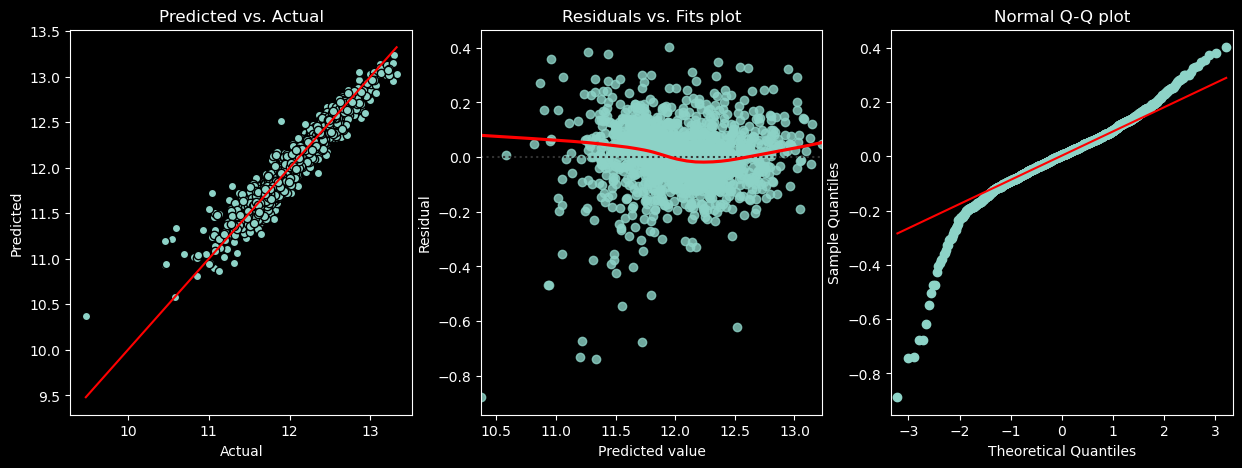

In [1314]:
return_plot(preds, y_train, resid)

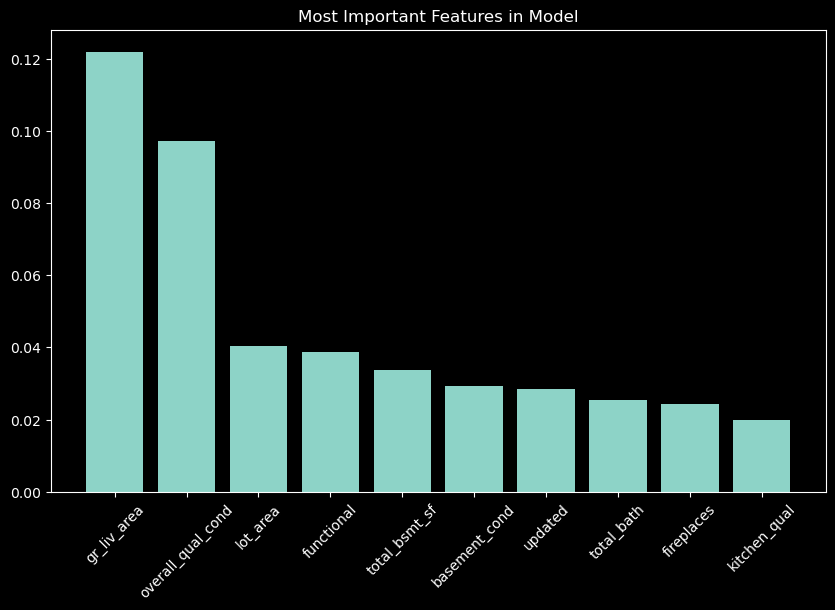

In [1315]:
plot_important_features(mlr_lasso, Xs_train, n_features=10)

### Columns Lasso is Minimizing

In [1316]:
squashed_columns = []
for idx, item in enumerate(mlr_lasso.coef_):
    if item == 0:
        squashed_columns.append(idx)
    
squashed_columns
Xs_train.iloc[:,squashed_columns].columns

Index(['lot_frontage', 'fence', 'alley', 'has_fireplace', 'Feedr', 'CBlock',
       'PConc', 'Slab', 'Duplex', 'Twnhs', 'Edwards', 'MeadowV', 'NAmes',
       'NoRidge', 'NridgHt', 'Somerst', 'land_house_ratio',
       'mas_vnr_area_outliers', 'total_bsmt_sf_outliers',
       'gr_liv_area_outliers', 'garage_area_outliers'],
      dtype='object')

### Instantiate Ridge Model

In [1317]:
mlr_ridge = Ridge()
#calculate residuals by creating predictions
mlr_ridge.fit(Xs_train,y_train)
preds = mlr_ridge.predict(Xs_train)
resid = y_train - preds

### Scores

In [1318]:
get_scores(mlr_ridge, standardize=True, log_price=log_flag)

Training R^2 Score:  0.9239234215736988
Training RMSE:  21034.968480826574
Cross Validation R^2 Score:  0.9159456692856534
Validation R^2 Score 0.8641885173204666


### Plots

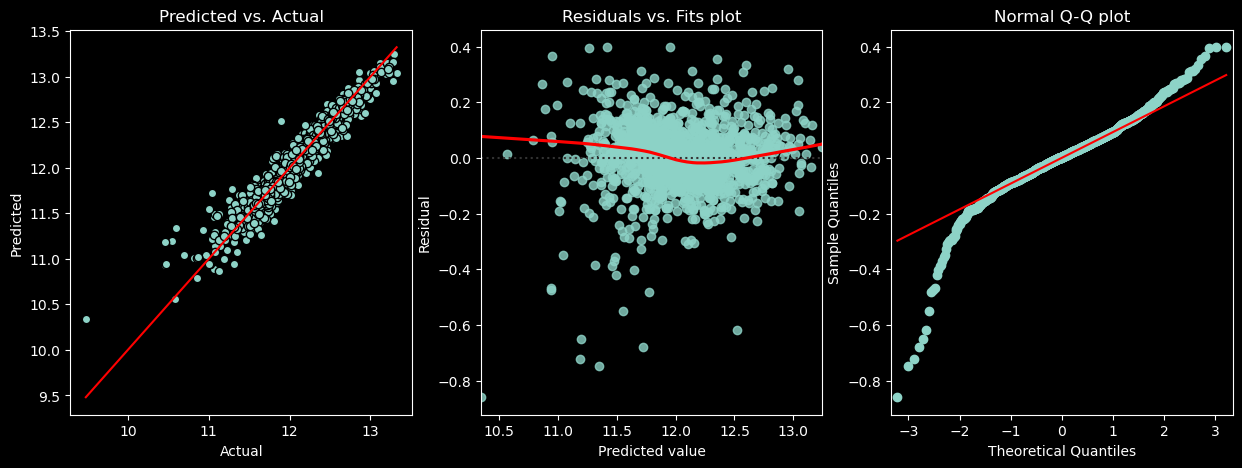

In [1319]:
return_plot(preds, y_train, resid)

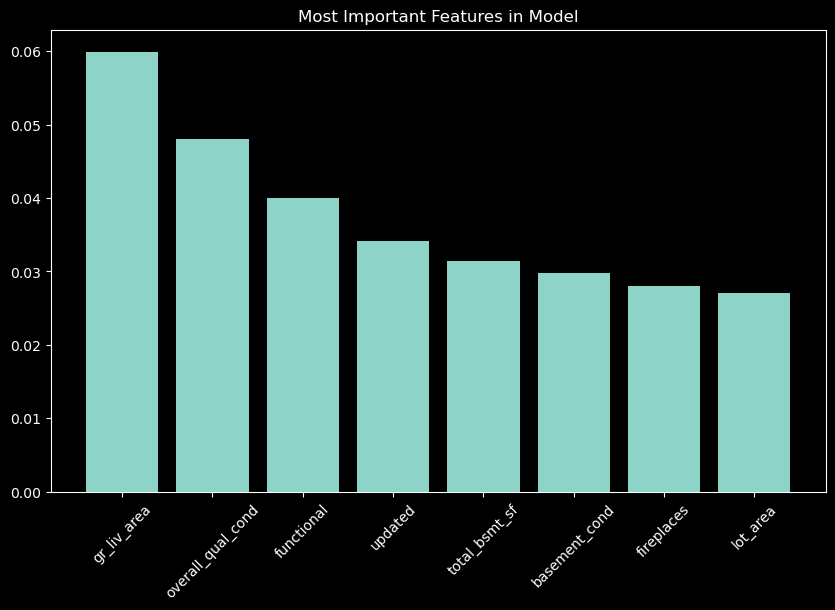

In [1320]:
plot_important_features(mlr_ridge, X_train, n_features=10)

### Instantiate OLS Model

In [1321]:
mlr_ols = LinearRegression()
#calculate residuals by creating predictions
mlr_ols.fit(Xs_train,y_train)
preds = mlr_ols.predict(Xs_train)
resid = y_train - preds

### Scores

In [1322]:
get_scores(mlr_ols, standardize=True, log_price=log_flag)

Training R^2 Score:  0.9239238205675032
Training RMSE:  21035.61739548861
Cross Validation R^2 Score:  -1059095288129168.8
Validation R^2 Score 0.8641370423595931


### Plots

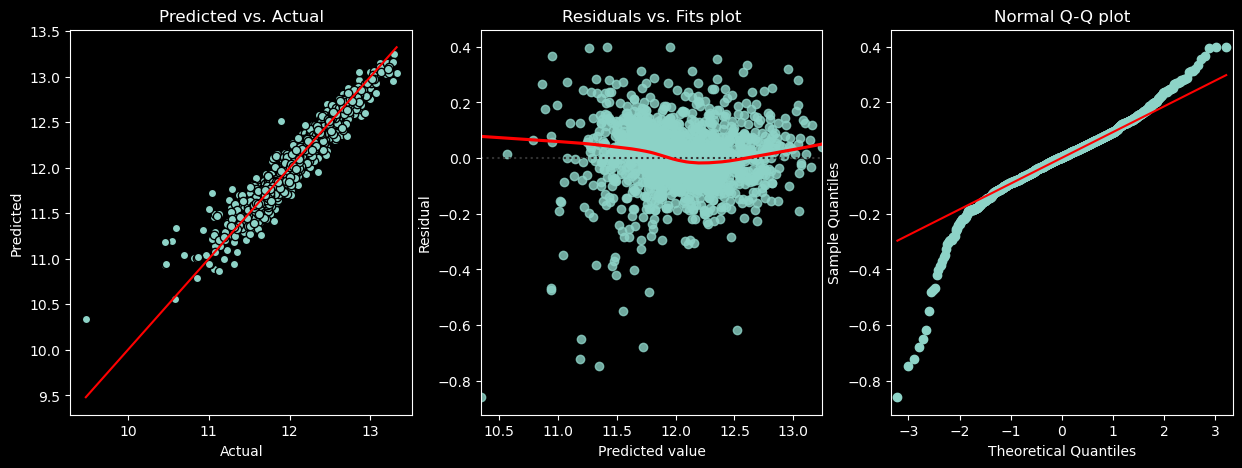

In [1323]:
return_plot(preds, y_train, resid)

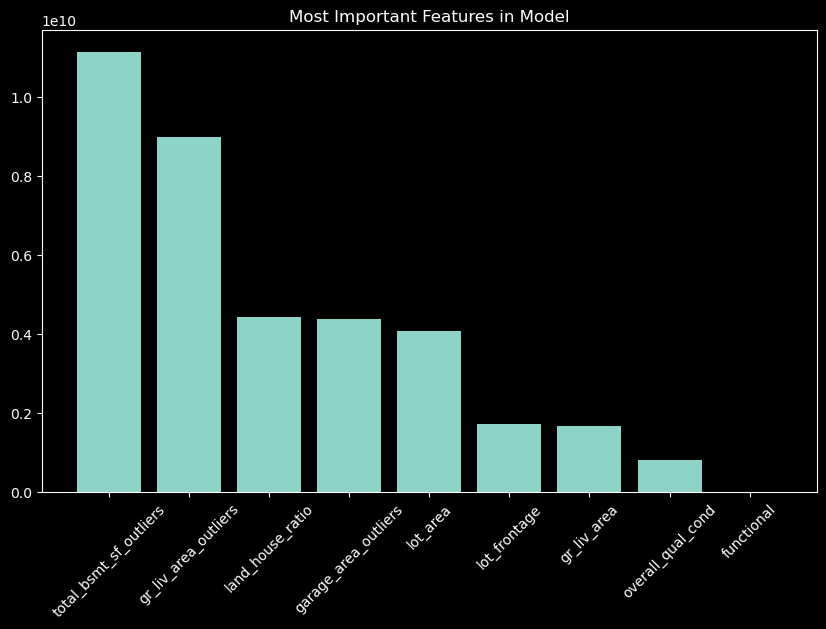

In [1324]:
plot_important_features(mlr_ols, X_train, n_features=10)

# Linear Assumptions

Variance Inflation Factor

In [1325]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF_Factor"] = [variance_inflation_factor(Xs_train.values, i) for i in range(Xs_train.shape[1])]
vif["features"] = Xs_train.columns;

vif.query('VIF_Factor > 5')

c:\Users\alexs\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF_Factor,features
3,6.310247,fireplaces
4,6.795609,garage_cars
5,inf,lot_frontage
6,inf,lot_area
9,inf,gr_liv_area
10,6.444644,garage_area
19,6.100033,has_fireplace
50,inf,overall_qual_cond
55,12.623028,neighborhood_price_rank
59,13.708560,house_age


Statsmodels

In [1326]:
X_sm = sm.add_constant(X_train)

res = sm.OLS(y_train, X_sm).fit()
preds = res.predict(sm.add_constant(X_test))
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     283.8
Date:                Tue, 06 Dec 2022   Prob (F-statistic):               0.00
Time:                        02:12:42   Log-Likelihood:                 1131.9
No. Observations:                1536   AIC:                            -2136.
Df Residuals:                    1472   BIC:                            -1794.
Df Model:                          63                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       7.2396      0.180     40.283      0.000       6.887       7.592
bedroom_abvgr              -0.0131      0.006     -2.271      0.023      -0.024      -0.002
kitchen_abvgr              -0.1003      0.026     -3.851      0.000      -0.151      -0.049
totrms_abvgrd               0.0087      0.004      2.121      0.034       0.001       0.017
fireplaces                  0.0438      0.012      3.706      0.000       0.021       0.067
garage_cars                 0.0126      0.010      1.236      0.217      -0.007       0.033
lot_frontage                0.0002      0.000      1.401      0.161   -6.74e-05       0.000
lot_area                    0.0806      0.005     17.007      0.000       0.071       0.090
mas_vnr_area             7.112e-05   2.25e-05      3.166      0.002    2.71e-05       0.000
total_bsmt_sf               0.0041      0.001      5.520      0.000       0.003       0.005
gr_liv_area                 0.1585      0.010     16.344      0.000       0.139       0.178
garage_area              7.301e-05   3.51e-05      2.080      0.038    4.15e-06       0.000
wood_deck_sf             9.919e-05   2.78e-05      3.567      0.000    4.46e-05       0.000
heating_qc                  0.0140      0.004      3.184      0.001       0.005       0.023
kitchen_qual                0.0260      0.007      3.493      0.000       0.011       0.041
functional                  0.0588      0.005     12.216      0.000       0.049       0.068
paved_drive                 0.0481      0.013      3.586      0.000       0.022       0.074
fence                      -0.0014      0.009     -0.161      0.872      -0.018       0.015
alley                      -0.0013      0.015     -0.088      0.930      -0.030       0.027
central_air                 0.0534      0.015      3.585      0.000       0.024       0.083
has_fireplace              -0.0116      0.015     -0.776      0.438      -0.041       0.018
Artery                      0.0008      0.025      0.034      0.973      -0.048       0.050
Feedr                       0.0149      0.022      0.684      0.494      -0.028       0.058
Norm                        0.0658      0.017      3.785      0.000       0.032       0.100
PosN                        0.0884      0.031      2.817      0.005       0.027       0.150
BrkTil                     -0.0174      0.014     -1.275      0.203      -0.044       0.009
CBlock                     -0.0356      0.123     -0.291      0.771      -0.276       0.205
PConc                       0.0030      0.011      0.267      0.790      -0.019       0.025
Slab                       -0.0096      0.035     -0.273      0.785      -0.078       0.059
1Fam                        0.0223      0.017      1.328      0.184      -0.011       0.055
2fmCon                      0.0481      0.030  

In [1327]:
# mlr_lasso.alpha_

# Submission

In [1328]:
#E instantiate lasso with best alpha 

new_lasso = Lasso(alpha = 0.001)
new_lasso.fit(X,y)

ss = StandardScaler()
Xs_test = ss.fit_transform(X_test)
Xs_test = pd.DataFrame(Xs_test, columns = ss.get_feature_names_out())



price_preds = new_lasso.predict(X_test)
house_test['SalePrice'] = np.exp(price_preds)

house_test
house_test[['id', 'SalePrice']].to_csv('../datasets/submission.csv', index = False)

In [1329]:
house_test[['id', 'SalePrice']]


,id,SalePrice
0,2658,112125.314468
1,2718,164095.543569
2,2414,230178.131504
3,1989,113244.888434
4,625,177463.960785
...,...,...
873,1662,182909.123576
874,1234,223173.418125
875,1373,131401.587533
876,1672,109834.572879


In [1335]:
current_df = house_test[['id', 'SalePrice']]
best_df = pd.read_csv('../datasets/best_submission.csv')
best_df = best_df.join(current_df.set_index('id'), on='id', lsuffix='_best', rsuffix='_current')
best_df['diff'] = best_df['SalePrice_best'] - best_df['SalePrice_current']
best_df.sort_values('diff', ascending=False)

,id,SalePrice_best,SalePrice_current,diff
170,1761,564067.5912,517324.478107,46743.113093
484,2215,287601.2624,266351.156644,21250.105756
463,1768,607542.8158,587678.979986,19863.835814
671,566,232437.2784,215120.498048,17316.780352
71,437,373340.8453,357363.750490,15977.094810
...,...,...,...,...
79,2399,349425.5020,367051.040660,-17625.538660
425,431,398813.5630,417574.203708,-18760.640708
525,1692,424294.1843,444504.249064,-20210.064764
85,427,320755.5303,344122.408627,-23366.878327


In [1340]:
ids = [1761, 2216, 1768]

In [1341]:
house_test.query('id in @ids')

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,condition_2,bldg_type,house_style,overall_cond,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_cond,foundation,bsmt_exposure,total_bsmt_sf,heating,heating_qc,central_air,electrical,gr_liv_area,bedroom_abvgr,kitchen_abvgr,kitchen_qual,totrms_abvgrd,functional,fireplaces,garage_type,garage_finish,garage_cars,garage_area,paved_drive,wood_deck_sf,pool_area,fence,misc_val,mo_sold,sale_type,has_fireplace,Artery,Feedr,Norm,PosA,PosN,RRAe,RRAn,RRNe,RRNn,Blmngtn,Blueste,BrDale,BrkSide,ClearCr,CollgCr,Crawfor,Edwards,Gilbert,Greens,IDOTRR,MeadowV,Mitchel,NAmes,NPkVill,NWAmes,NoRidge,NridgHt,OldTown,SWISU,Sawyer,SawyerW,Somerst,StoneBr,Timber,Veenker,1Fam,2fmCon,Duplex,Twnhs,TwnhsE,AsbShng,AsphShn,BrkComm,BrkFace,CemntBd,HdBoard,MetalSd,Plywood,Stucco,VinylSd,Wd Sdng,WdShing,BrkTil,CBlock,PConc,Slab,Stone,Wood,CompShg,Tar&Grv,WdShake,WdShngl,AllPub,NoSewr,Artery.1,Feedr.1,Norm.1,PosA.1,PosN.1,RRAe.1,RRAn.1,RRNe.1,RRNn.1,overall_qual_cond,basement_cond,2nd_story,total_bath,total_porch_sf,neighborhood_price_rank,updated,garage_age,garage_qual_cond,house_age,land_house_ratio,has_pool,meltdown,lot_frontage_outliers,lot_area_outliers,mas_vnr_area_outliers,total_bsmt_sf_outliers,gr_liv_area_outliers,garage_area_outliers,lot_frontage_poly,lot_area_poly,gr_liv_area_poly,overall_qual_cond_poly,SalePrice
170,1761,528320050,60,RL,160.0,9.656499,Pave,0,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,5,Hip,CompShg,Wd Sdng,ImStucc,None,0.0,2,PConc,NaN,48.948953,GasA,4,1,SBrkr,8.406485,4,1,4,10,3,2,Attchd,Fin,3,813,1,171,555,1,0,7,WD,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,6.5,3.0,1,4.5,78,2,0,11.0,2.0,3.316625,1.250014,1,0,1,1,1,1,1,1,25600.0,244078129,20034576,42.25,517324.478107
463,1768,528351010,60,RL,104.0,9.977435,Pave,0,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,6,Gable,WdShngl,HdBoard,HdBoard,BrkFace,1170.0,2,PConc,3.0,49.436828,GasA,4,1,SBrkr,8.370084,4,1,4,10,3,2,Attchd,Fin,3,832,1,382,0,0,0,1,WD,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,7.0,3.0,1,4.0,50,2,1,13.0,2.0,3.605551,1.607350,0,0,0,0,0,0,0,0,10816.0,463756225,18627856,49.00,587678.979986


<AxesSubplot:xlabel='SalePrice_best', ylabel='id'>

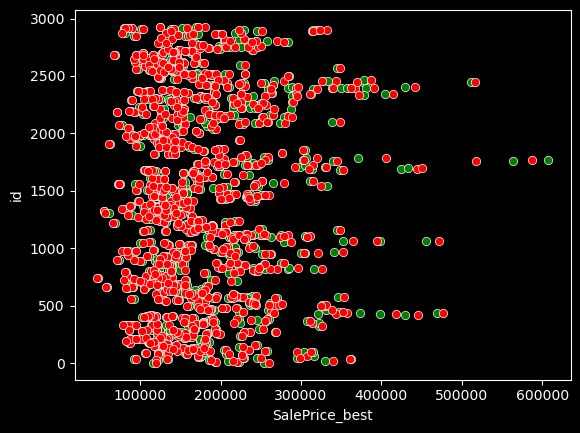

In [1331]:
sns.scatterplot(best_df, x = 'SalePrice_best', y = 'id', color = 'green')
sns.scatterplot(best_df, x = 'SalePrice_current', y = 'id', color = 'red')
